In [ ]:
#Basic libraries
import pandas as pd
import numpy as np

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#ML libraries
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



#Misc libraries
import warnings
warnings.filterwarnings("ignore")

# 🏧 Dataset
> Here we just import the first 50000 rows since the dataset is huge and would take a long time to process. Let's see the overview of data

In [ ]:
#Reading the data
paysim=pd.read_csv('content/PS_20174392719_1491204439457_log.csv')

#Looking at the data
paysim.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
paysim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Dataset description
>1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
3. amount - amount of the transaction in local currency.
4. nameOrig - customer who started the transaction
5. oldbalanceOrg - initial balance before the transaction
6. newbalanceOrig - new balance after the transaction
7. nameDest - customer who is the recipient of the transaction
8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# 📋 Pivot table analysis
>  Numbers is everything in transaction monitoring. Numbers decide whether it is a fraudulent activity or not. Let us look at the overall numbers using pivot function

In [ ]:
#Pivot table
paysim_pivot1=pd.pivot_table(paysim,index=["type"],
                               values=['amount','isFraud','isFlaggedFraud'],
                               aggfunc=[np.sum,np.std], margins=True)

#Adding color gradient
cm = sns.light_palette("green", as_cmap=True)
paysim_pivot1.style.background_gradient(cmap=cm)

In [ ]:
#Pivot table
paysim_pivot2=pd.pivot_table(paysim,index=["type"],
                               values=['amount','oldbalanceOrg','newbalanceOrig'],
                               aggfunc=[np.sum], margins=True)

#Adding style
paysim_pivot2.style\
    .format('{:.2f}')\
    .bar(align='mid',color=['darkred'])\
    .set_properties(padding='5px',border='3px solid white',width='200px')

In [ ]:
#Pivot table
paysim_pivot3=pd.pivot_table(paysim,index=["type"],
                               values=['amount','oldbalanceDest','newbalanceDest'],
                               aggfunc=[np.sum], margins=True)

#Adding style
paysim_pivot3.style\
    .format('{:.2f}')\
    .bar(align='mid',color=['darkblue'])\
    .set_properties(padding='5px',border='3px solid white',width='200px')

## 📊 Distribution of Amount
>  It is important to understand the distribution of our data, since it can play a major role in model building and also in understanding our data. Going forward we will be using only 50k rows as it takes a lot of time to process all the records for viz and model building.
> Here we check for the distribution of amount transacted using the application

In [ ]:
#Reading the first 50000 rows
paysim=pd.read_csv('/content/PS_20174392719_1491204439457_log.csv',nrows=50000)

#Distribution of Amount
fig = px.box(paysim, y="amount")
fig.show()

# 🔧 Feature engineering
>  Time to get our hands dirty with feature engineering. With the available information it is hard to train the model and get better results. Hence we move onto create new features by altering the existing features. In this we create three functions which creates a highly relevant feature for the domain
>
> 1. **Difference in balance:** It is an universal truth that the amount debited from senders account gets credited into the receivers account without any deviation in cents. But what if there is a deviation incase of the amount debited and credited. Some could be due to the charges levied by the service providers, yet we need to flag such unusual instances
> 2. **Surge indicator:** Also we have to trigger flag when large amount are involved in the transaction. From the distribution of amount we understood that we have a lot of outliers with high amount in transactions. Hence we consider the 75th percentile(450k) as our threshold and amount which is greater than 450k will be triggered as a flag
> 3. **Frequency indicator:** Here we flag the user and not the transaction. When there is a receiver who receives money from a lot of people, it could be a trigger as it can be for some illegal games of chance or luck. Hence it is flagged when there is a receiver who receives money for more than 20 times.
>4. **Merchant indicator:** The customer ids in receiver starts with 'M' which means that they are merchants and they obviously will have a lot of receiving transactions. So we also flag whenever there is a merchant receiver

In [ ]:
#Tallying the balance
def balance_diff(data):
    '''balance_diff checks whether the money debited from sender has exactly credited to the receiver
       then it creates a new column which indicates 1 when there is a deviation else 0'''
    #Sender's balance
    orig_change=data['newbalanceOrig']-data['oldbalanceOrg']
    orig_change=orig_change.astype(int)
    for i in orig_change:
        if i<0:
            data['orig_txn_diff']=round(data['amount']+orig_change,2)
        else:
            data['orig_txn_diff']=round(data['amount']-orig_change,2)
    data['orig_txn_diff']=data['orig_txn_diff'].astype(int)
    data['orig_diff'] = [1 if n !=0 else 0 for n in data['orig_txn_diff']]

    #Receiver's balance
    dest_change=data['newbalanceDest']-data['oldbalanceDest']
    dest_change=dest_change.astype(int)
    for i in dest_change:
        if i<0:
            data['dest_txn_diff']=round(data['amount']+dest_change,2)
        else:
            data['dest_txn_diff']=round(data['amount']-dest_change,2)
    data['dest_txn_diff']=data['dest_txn_diff'].astype(int)
    data['dest_diff'] = [1 if n !=0 else 0 for n in data['dest_txn_diff']]

    data.drop(['orig_txn_diff','dest_txn_diff'],axis=1,inplace = True)

#Surge indicator
def surge_indicator(data):
    '''Creates a new column which has 1 if the transaction amount is greater than the threshold
    else it will be 0'''
    data['surge']=[1 if n>450000 else 0 for n in data['amount']]

#Frequency indicator
def frequency_receiver(data):
    '''Creates a new column which has 1 if the receiver receives money from many individuals
    else it will be 0'''
    data['freq_Dest']=data['nameDest'].map(data['nameDest'].value_counts())
    data['freq_dest']=[1 if n>20 else 0 for n in data['freq_Dest']]

    data.drop(['freq_Dest'],axis=1,inplace = True)

#Tracking the receiver as merchant or not
def merchant(data):
    '''We also have customer ids which starts with M in Receiver name, it indicates merchant
    this function will flag if there is a merchant in receiver end '''
    values = ['M']
    conditions = list(map(data['nameDest'].str.contains, values))
    data['merchant'] = np.select(conditions, '1', '0')

In [ ]:
#Applying balance_diff function
balance_diff(paysim)

paysim['orig_diff'].value_counts()
paysim['dest_diff'].value_counts()

1    44994
0     5006
Name: dest_diff, dtype: int64

In [ ]:
#Applying surge_indicator function
surge_indicator(paysim)
paysim['surge'].value_counts()

0    46392
1     3608
Name: surge, dtype: int64

In [ ]:
#Applying frequency_receiver function
frequency_receiver(paysim)
paysim['freq_dest'].value_counts()

0    46295
1     3705
Name: freq_dest, dtype: int64

# ⚙️ Pre-processing data
>  Before moving to build a machine learning model, it is mandatory to pre-process the data so that the model trains without any error and can learn better to provide better results

## 1. Balancing the target
> From the pie chart below we can clearly see that the target label is heavily imbalance as we have only 0.2% of fraudulent data which is in-sufficient for machine to learn and flag when fraud transactions happen.

In [ ]:
#Creating a copy
paysim_1=paysim.copy()

#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=paysim_1['isFraud'].value_counts())])
fig.show()

In [ ]:
#Getting the max size
max_size = paysim_1['isFraud'].value_counts().max()

#Balancing the target label
lst = [paysim_1]
for class_index, group in paysim_1.groupby('isFraud'):
    lst.append(group.sample(max_size-len(group), replace=True))
paysim_1 = pd.concat(lst)

In [ ]:
#Checking the balanced target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=paysim_1['isFraud'].value_counts())])
fig.show()

## 2. One hot encoding
> One of the most important feature we have is type which is categorical in type. Since it doesnt have any ordinal nature and since the classes are less, we prefer applying one hot encoding.

In [ ]:
#One hot encoding
paysim_1=pd.concat([paysim_1,pd.get_dummies(paysim_1['type'], prefix='type_')],axis=1)
paysim_1.drop(['type'],axis=1,inplace = True)

paysim_1.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_diff,dest_diff,surge,freq_dest,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,1,0,0,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0


## 3. Split and Standardize
> In this module we create the independent and dependent feature, then split them into train and test data where training size is 70%. Later we collect all the numerical features and apply StandardScaler() function which transforms the distribution so that the mean becomes 0 and standard deviation becomes 1

In [ ]:
#Splitting dependent and independent variable
paysim_2=paysim_1.copy()
X=paysim_2.drop('isFraud',axis=1)
y=paysim_2['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=111)

#Standardizing the numerical columns
col_names=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
features_train = X_train[col_names]
features_test = X_test[col_names]
scaler = StandardScaler().fit(features_train.values)
features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)
X_train[col_names] = features_train
X_test[col_names] =features_test

## 3. Tokenization
> We had the customer ids and merchant ids stored in object type. It is bad to apply one hot encoding in it as it can lead to more features and curse of dimensionality can incur. Hence we are applying tokenization here as it can create an unique id number which is in 'int' type for each customer id

In [ ]:
#Tokenzation of customer name to get a unique id
tokenizer_org = tf.keras.preprocessing.text.Tokenizer()
tokenizer_org.fit_on_texts(X_train['nameOrig'])

tokenizer_dest = tf.keras.preprocessing.text.Tokenizer()
tokenizer_dest.fit_on_texts(X_train['nameDest'])

# Create tokenized customer lists
customers_train_org = tokenizer_org.texts_to_sequences(X_train['nameOrig'])
customers_test_org = tokenizer_org.texts_to_sequences(X_test['nameOrig'])

customers_train_dest = tokenizer_dest.texts_to_sequences(X_train['nameDest'])
customers_test_dest = tokenizer_dest.texts_to_sequences(X_test['nameDest'])


# Pad sequences
X_train['customers_org'] = tf.keras.preprocessing.sequence.pad_sequences(customers_train_org, maxlen=1)
X_test['customers_org'] = tf.keras.preprocessing.sequence.pad_sequences(customers_test_org, maxlen=1)

X_train['customers_dest'] = tf.keras.preprocessing.sequence.pad_sequences(customers_train_dest, maxlen=1)
X_test['customers_dest'] = tf.keras.preprocessing.sequence.pad_sequences(customers_test_dest, maxlen=1)

### Dropping unnecessary columns
> We dont need the sender and receiver id as we have tokenized them, also we dont required isFlaggedFraud as it is just an outcome of current algorithm.

In [ ]:
#Dropping unnecessary columns
X_train=X_train.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
X_train = X_train.reset_index(drop=True)

X_test=X_test.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
X_test = X_test.reset_index(drop=True)

# 🤖 Model Building
> We have successfully processed the data and it is time for serving the data to the model. It is time consuming to find out which model works best for our data. Hence I have utlized pipeline to run our data through all the classification algorithm and select the best which gives out the maximum accuracy.

In [ ]:
#creating the objects
logreg_cv = LogisticRegression(solver='liblinear',random_state=123)
dt_cv=DecisionTreeClassifier(random_state=123)
knn_cv=KNeighborsClassifier()
svc_cv=SVC(kernel='linear',random_state=123)
nb_cv=GaussianNB()
rf_cv=RandomForestClassifier(random_state=123)
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes',5:'Random Forest'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv,rf_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X_train, y_train, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9655167477812767
Decision Tree Test Accuracy: 0.9749498997995992
KNN Test Accuracy: 0.9877755511022045
SVC Test Accuracy: 0.9756369882622387
Naive Bayes Test Accuracy: 0.9946321213856283
Random Forest Test Accuracy: 0.9931291153736044


## ⛮ Hyperparameter Tuning
> Lets fit the Naive bayes model by tuning the model with its parameters. Here we are gonna tune var_smoothing which is a stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean. In this case, np.logspace returns numbers spaced evenly on a log scale, starts from 0, ends at -9, and generates 100 samples.

In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.6s


GaussianNB(var_smoothing=8.111308307896856e-09)


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.1s finished


# 🧪 Evaluation of model
> Time to explore the truth of high numbers by evaluating against testing data

In [ ]:
#Function for Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


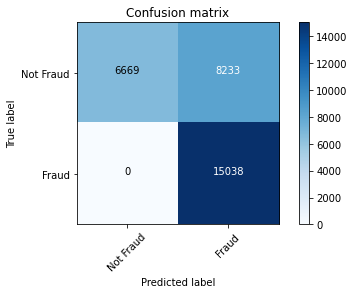

In [ ]:
#Predict with the selected best parameter
y_pred=nbModel_grid.predict(X_test)

#Plotting confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Not Fraud','Fraud'])

In [ ]:
#Classification metrics
print(classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       1.00      0.45      0.62     14902
       Fraud       0.65      1.00      0.79     15038

    accuracy                           0.73     29940
   macro avg       0.82      0.72      0.70     29940
weighted avg       0.82      0.73      0.70     29940

